# EDA - Exploratory Data Analysis


In [1]:
from collections import Counter

import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from networkx.algorithms import bipartite
import matplotlib.ticker as mtick
import powerlaw as pl

path = "data/figures/presentation/"
G = nx.Graph()

f = open("data/raw/u.data")
for line in f.readlines():
    source, target, weight = line.split()
    G.add_node(source + "a", bipartite=0, id=source)
    G.add_node(target + "b", bipartite=1, id=target)
    G.add_edge(source + "a", target + "b", weight=weight)

# print(G)

## Degree Distribution
It is just a degree scatter plot: the number of nodes with a particular degree. The degree should be on the x axis and the number
of nodes on the y axis. 

In [2]:
def plot_histogram(data, xlabel, ylabel, title, filename):
    plt.hist(data, bins=100, color='#E37F51')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.yscale("log")
    plt.rcParams['axes.labelcolor'] = '#000000'
    plt.rcParams['xtick.color'] = '#000000'
    plt.rcParams['ytick.color'] = '#000000'
    plt.rcParams['axes.titlecolor'] = '#000000'
    plt.savefig(path+filename, dpi=600,transparent=True)
    plt.show()


### Degree Distribution of Users
The degree distribution of user nodes (left partition):

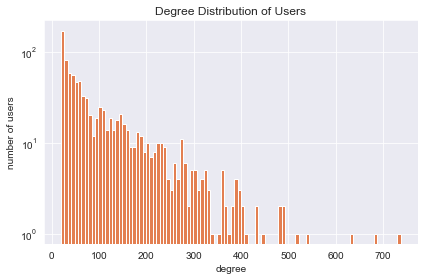

,k,count
4,20,32
119,21,24
88,22,23
34,23,21
27,24,21
...,...,...
35,518,1
208,540,1
53,636,1
249,685,1


In [3]:
# user degree distribution
user_degree = [G.degree(n) for n in G.nodes() if G.nodes[n]['bipartite'] == 0]
dd_user = Counter(user_degree) 
dd_user = pd.DataFrame(list(dd_user.items()), columns = ("k", "count")).sort_values(by = "k")

plot_histogram(user_degree, "degree", "number of users","Degree Distribution of Users", "dd_user.png")
dd_user

### Degree Distribution of Movies
THe degree distribution of movie nodes (right partition):

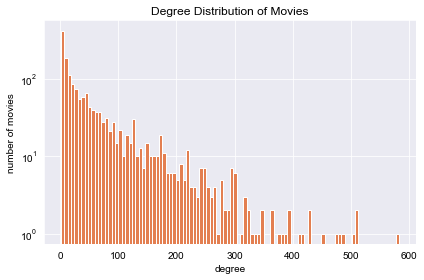

,k,count
269,1,141
220,2,68
252,3,60
234,4,64
231,5,51
...,...,...
80,485,1
49,507,1
46,508,1
125,509,1


In [4]:
# movie degree distribution
movie_degree = [G.degree(n) for n in G.nodes() if G.nodes[n]['bipartite'] == 1]
dd_movie = Counter(movie_degree) 
dd_movie = pd.DataFrame(list(dd_movie.items()), columns = ("k", "count")).sort_values(by = "k")

plot_histogram(movie_degree, "degree", "number of movies","Degree Distribution of Movies", "dd_movie.png")
dd_movie

## CCDF - Complementary Cumulative Distribution Function
The CCDF gives us the probability $P(K≥k)$ that a randomly chosen node will have degree greater than or equal to $k$. A linear relationship in a log-log plot of the CCDF is indicative of a power-law distribution, which is common in many real-world networks.

In [5]:
def plot_CCDF(ccdf, xlabel, ylabel, title, filename):
    ccdf.plot(kind = "line", x = "k", y = "ccdf", loglog=True, color='#E37F51')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    plt.rcParams['axes.labelcolor'] = '#000000'
    plt.rcParams['axes.titlecolor'] = '#000000'
    plt.savefig(path+filename, dpi=600,transparent=True)
    plt.show()

### CCDF for Users
This plot shows the probability that a user has rated at least $k$ movies. As expected, the probability decreases as the degree increases.

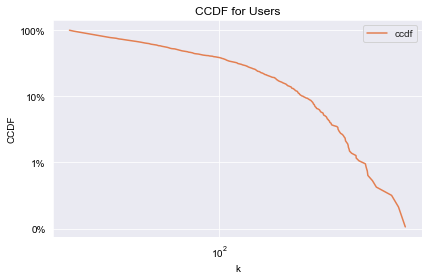

,k,ccdf
4,20,1.000000
119,21,0.966066
88,22,0.940615
34,23,0.916225
27,24,0.893955
...,...,...
35,518,0.005302
208,540,0.004242
53,636,0.003181
249,685,0.002121


In [6]:
ccdf_user = dd_user.sort_values(by = "k", ascending = False) #sort in descending order
ccdf_user["cumsum"] = ccdf_user["count"].cumsum() 
ccdf_user["ccdf"] = ccdf_user["cumsum"] / ccdf_user["count"].sum()# normalize the data
ccdf_user = ccdf_user[["k", "ccdf"]].sort_values(by = "k") #sort by ascending degree


plot_CCDF(ccdf_user, "k", "CCDF", "CCDF for Users", "ccdf_user.png")
ccdf_user

### CCDF for Movies
This plot shows the probability that a movie has been rated by at least $k$ users. Again, the probability decreases as the degree increases.

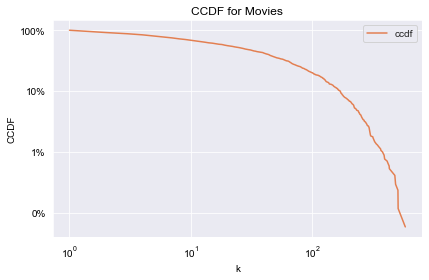

,k,ccdf
269,1,1.000000
220,2,0.916171
252,3,0.875743
234,4,0.840071
231,5,0.802021
...,...,...
80,485,0.002973
49,507,0.002378
46,508,0.001784
125,509,0.001189


In [7]:
ccdf_movie = dd_movie.sort_values(by = "k", ascending = False) #sort in descending order
ccdf_movie["cumsum"] = ccdf_movie["count"].cumsum() 
ccdf_movie["ccdf"] = ccdf_movie["cumsum"] / ccdf_movie["count"].sum()# normalize the data
ccdf_movie = ccdf_movie[["k", "ccdf"]].sort_values(by = "k") #sort by ascending degree


plot_CCDF(ccdf_movie, "k", "CCDF", "CCDF for Movies", "ccdf_movie.png")
ccdf_movie

## Power Law
The *Power Law* implies that a small amount of occurences is common, while larger occurences are rare.

### Power Law for Users
We want to see if power law fit works for user partition:


Calculating best minimal value for power law fit


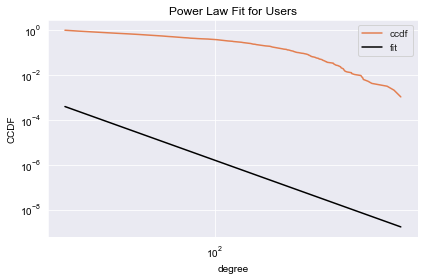

In [8]:
results = pl.Fit(ccdf_user["ccdf"])
k_min_user = ccdf_user[ccdf_user["ccdf"] == results.power_law.xmin]["k"]

ccdf_user["fit"] = (10 ** results.power_law.Kappa) * (ccdf_user["k"] ** -results.power_law.alpha)
ax = plt.gca()
ccdf_user.plot(kind = "line", x = "k", y = "ccdf", color = "#E37F51", loglog = True, ax = ax)
ccdf_user.plot(kind = "line", x = "k", y = "fit", color = "#000000", loglog = True, ax = ax)
plt.xlabel("degree")
plt.ylabel("CCDF")
plt.title("Power Law Fit for Users")
plt.tight_layout()
plt.savefig(path+"ccdf_fit_users.png", transparent=True, dpi=600)

### Power Law Fit for Movies
Now let's check if power law fit works for movies:

Calculating best minimal value for power law fit


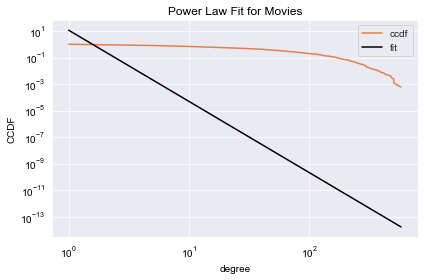

In [9]:
results = pl.Fit(ccdf_movie["ccdf"])
k_min_movie = ccdf_movie[ccdf_movie["ccdf"] == results.power_law.xmin]["k"]

ccdf_movie["fit"] = (10 ** results.power_law.Kappa) * (ccdf_movie["k"] ** -results.power_law.alpha)
ax = plt.gca()
ccdf_movie.plot(kind = "line", x = "k", y = "ccdf", color = "#E37F51", loglog = True, ax = ax)
ccdf_movie.plot(kind = "line", x = "k", y = "fit", color = "#000000", loglog = True, ax = ax)
plt.xlabel("degree")
plt.ylabel("CCDF")
plt.title("Power Law Fit for Movies")
plt.tight_layout()
plt.savefig(path+"ccdf_fit_movies.png", transparent=True, dpi=600)